### Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

In [4]:
os.listdir('../input/version-8-indian-dance-forms/IndianDanceForms2')

['test', 'test.csv', 'train.csv', 'valid.csv', 'train']

### Config Files

In [5]:
base_path = '../input/version-8-indian-dance-forms/IndianDanceForms2'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))
# valid_df = pd.read_csv('../input/validation-data/valid.csv')
valid_df = pd.read_csv(os.path.join(base_path, 'valid.csv'))
valid_dir = os.path.join(base_path, 'test')
test_df['target'] = ['manipuri']*len(test_df)
if not os.path.isdir('output'):
    os.mkdir('output')
ouput_dir = 'output'

idx_class_labels = {
    0: 'bharatanatyam',
    1: 'kathak', 
    2: 'kathakali',
    3: 'kuchipudi',
    4: 'manipuri',
    5: 'mohiniyattam',
    6: 'odissi',
    7: 'sattriya'
}
class_idx_labels = {
    'bharatanatyam': 0,
    'kathak': 1,
    'kathak ': 1,
    'kathakali': 2,
    'kuchipudi': 3,
    'manipuri': 4,
    'mohiniyattam': 5,
    'odissi': 6,
    'sattriya': 7
}

num_classes = len(idx_class_labels.items())
val_size = 0.1
## Model Config
torch.manual_seed(10)

### Utility Functions

In [6]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print("Label" ,decode_target(int(target), text_labels=True))
    
def show_difference(img1, target1, img2, target2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.set_title("Before Transformation")
    ax1.imshow(img1.permute(1, 2 ,0))
    ax2.set_title("After Transformation")
    ax2.imshow(img2.permute(1, 2 ,0))
    
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
def encode_label(label):
    idx = class_idx_labels[label] 
    return idx

def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return idx_class_labels[target]
    else:
        return target
## Example
# print(encode_label('manipuri'), decode_target(2))
# print( decode_target(2, text_labels=True))

## Creating Dataset and Dataloaders
### Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers.

In [7]:
class IndianDanceForms(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['Image'], row['target']
        img = Image.open(os.path.join(self.train_dir, img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

## For K-fold cross validation

In [8]:
# train_df["kfold"] = -1
# train_df = train_df.sample(frac=1).reset_index(drop=True)
# y = train_df.target.values
# kf = model_selection.StratifiedKFold(n_splits=10)
# for folds_, (t_, v_) in enumerate(kf.split(X=train_df, y=y)):
#     train_df.loc[v_, "kfold"] = folds_
# train_df.head()

### Applying Transformations

In [9]:
padding = (10, 15, 20, 30)
train_transform = transforms.Compose([
                                transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(degrees=(-10,+10)),
                                transforms.RandomAffine(0, translate=None, scale=(0.9, 1.1), shear=1, resample=False, fillcolor=0),
                                transforms.Pad(padding, fill=0, padding_mode='reflect'),
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
valid_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = IndianDanceForms(train_df, train_dir, train_transform)
valid_ds = IndianDanceForms(valid_df, valid_dir, valid_transform)
print(len(train_ds), len(valid_ds))

1335 156


### Consideration of transformations

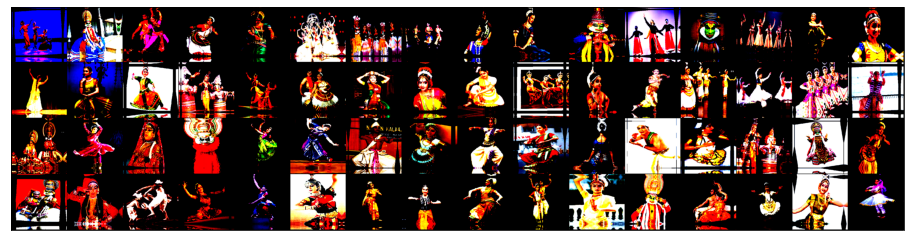

In [10]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

### Model

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
# network = models.wide_resnet101_2(pretrained=True)
# network

In [13]:
class DanceFormModel(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, 8),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True
    


In [14]:
# class DanceFormModel(MulticlassClassifierBase):
#     def __init__(self):
#         super().__init__()
#         self.network = models.resnet50(pretrained=True)
#         n_inputs = self.network.fc.in_features
#         self.network.fc = nn.Sequential(
#                               nn.Linear(n_inputs, 256),
#                               nn.ReLU(),
#                               nn.Dropout(0.5),
#                               nn.Linear(256, 8),
#                               nn.LogSoftmax(dim=1)
#                                 )
#     def forward(self, xb):
#         return self.network(xb)
    
#     def freeze(self):
#         for param in self.network.parameters():
#             param.require_grad=False
#         for param in self.network.fc.parameters():
#             param.require_grad=True
#     def unfreeze(self):
#         for param in self.network.parameters():
#             param.require_grad=True
    

In [15]:
model = DanceFormModel()

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/checkpoints/wide_resnet50_2-95faca4d.pth


### Checking how each batch goes through model

In [16]:
# def try_batch(dl):
#     for images, labels in dl:  
#         print(images.shape)
#         out = model(images)
#         print(out.shape)
#         print(out[0])
#         break
# try_batch(train_dl)    

## Training and Evaluating

In [17]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0, grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
    history = []
    
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'indian_dance_form.pth'
    model_file_name2 = 'indian_dance_form_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
#         scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

## Initializing Device also Loading Data and Model to device

In [18]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [19]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(DanceFormModel(), device)
## lets try passing a batch to model again
# try_batch(train_dl)

True


In [20]:
torch.cuda.empty_cache()

Check how evaluation works

# Training

In [22]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 25
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, valid_dl)

{'val_loss': 2.087596893310547, 'val_acc': 0.098214291036129}

In [23]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.3141, learning_rate: 0.0001, train_loss: 1.8270, val_loss: 1.1760, val_acc: 0.5744


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.7220, learning_rate: 0.0001, train_loss: 1.0186, val_loss: 0.4331, val_acc: 0.9226


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.8822, learning_rate: 0.0001, train_loss: 0.4607, val_loss: 0.2265, val_acc: 0.9293


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9352, learning_rate: 0.0001, train_loss: 0.2573, val_loss: 0.1278, val_acc: 0.9792


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9590, learning_rate: 0.0001, train_loss: 0.1757, val_loss: 0.3313, val_acc: 0.8914


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9657, learning_rate: 0.0001, train_loss: 0.1234, val_loss: 0.0629, val_acc: 0.9844


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9857, learning_rate: 0.0001, train_loss: 0.0737, val_loss: 0.0733, val_acc: 0.9844


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9856, learning_rate: 0.0001, train_loss: 0.0623, val_loss: 0.1379, val_acc: 0.9621


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9909, learning_rate: 0.0001, train_loss: 0.0495, val_loss: 0.0381, val_acc: 0.9844


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9747, learning_rate: 0.0001, train_loss: 0.0751, val_loss: 0.0634, val_acc: 0.9844


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9879, learning_rate: 0.0001, train_loss: 0.0632, val_loss: 0.1267, val_acc: 0.9635


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9777, learning_rate: 0.0001, train_loss: 0.0765, val_loss: 0.0478, val_acc: 0.9896


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9803, learning_rate: 0.0001, train_loss: 0.0818, val_loss: 0.2283, val_acc: 0.9308


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9737, learning_rate: 0.0001, train_loss: 0.0864, val_loss: 0.2295, val_acc: 0.9345


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9790, learning_rate: 0.0001, train_loss: 0.0740, val_loss: 0.0264, val_acc: 1.0000


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.9789, learning_rate: 0.0001, train_loss: 0.0546, val_loss: 0.0671, val_acc: 0.9725


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.9828, learning_rate: 0.0001, train_loss: 0.0701, val_loss: 0.0370, val_acc: 0.9829


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.9857, learning_rate: 0.0001, train_loss: 0.0459, val_loss: 0.0380, val_acc: 0.9896


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.9896, learning_rate: 0.0001, train_loss: 0.0420, val_loss: 0.1181, val_acc: 0.9568


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.9947, learning_rate: 0.0001, train_loss: 0.0305, val_loss: 0.0491, val_acc: 0.9844


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [20],train_accu: 0.9902, learning_rate: 0.0001, train_loss: 0.0439, val_loss: 0.0422, val_acc: 0.9948


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [21],train_accu: 0.9881, learning_rate: 0.0001, train_loss: 0.0389, val_loss: 0.0387, val_acc: 0.9896


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [22],train_accu: 0.9888, learning_rate: 0.0001, train_loss: 0.0442, val_loss: 0.1447, val_acc: 0.9568


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [23],train_accu: 0.9835, learning_rate: 0.0001, train_loss: 0.0502, val_loss: 0.1148, val_acc: 0.9740


100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


Epoch [24],train_accu: 0.9887, learning_rate: 0.0001, train_loss: 0.0387, val_loss: 0.0506, val_acc: 0.9896
VAL LOSS MIN 0.026445774361491203
VAL ACC MAX 1.0


## Visualize

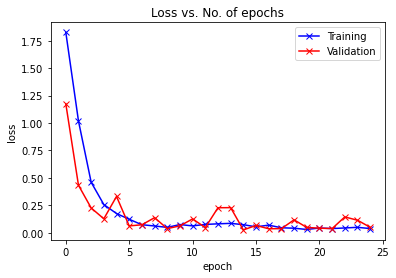

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

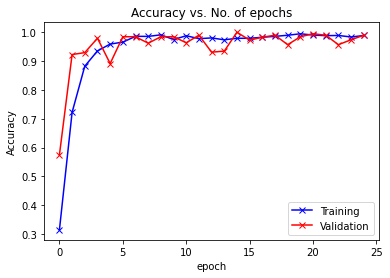

In [25]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

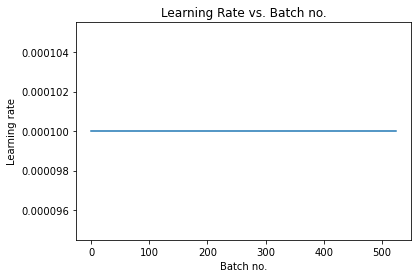

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

## Wrong Predictions

In [27]:
# for img, label in tqdm(valid_dl):
#     output = model(img)
#     _, pred = torch.max(output.cpu().detach(), dim=1)
#     if pred != label:
#         wrong_images.append(img)

In [28]:
batch_size =1
transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
test_dataset = IndianDanceForms(test_df, test_dir, transform = transform)
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=0, pin_memory=False), device)
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())        
    return [decode_target(int(x), text_labels=True) for x in batch_pred]
def submitting(test_dl, model, sub_fname):
    test_preds = predict_dl(test_dl, model)
    submission_df = test_df
    submission_df['target'] = test_preds
    submission_df.head()
    submission_df.to_csv(sub_fname, index=False)
    return submission_df

In [29]:
model.load_state_dict(torch.load('./indian_dance_form.pth'))
submission_df = submitting(test_dl, model, 'submission.csv')
# model.load_state_dict(torch.load('./indian_dance_form_max_acc.pth'))
# submission_df = submitting(test_dl, model, 'submission_with_acc.csv')

100%|██████████| 156/156 [00:04<00:00, 33.28it/s]


In [30]:
### Predict Single Images
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)
#     print("Prediction: ", int(prediction), decode_target(int(prediction), text_labels=True))
#     show_sample(image, prediction)
# predict_single(valid_ds[8][0])

## Checking the wrong one

In [31]:
wrong_id = []
for i in range(len(valid_ds)):
    preds = predict_single(valid_ds[i][0])
    img, target = valid_ds[i]
    target = decode_target(target)
    if preds != target:
        wrong_id.append(i)
len(wrong_id)
# wrong_id

0

In [32]:
img_ll = []
label_ll = []
predicted_ll = []
for ind1 in valid_df.index:
    for ind2 in submission_df.index:
        if valid_df['Image'][ind1] == submission_df['Image'][ind2]:
            if valid_df['target'][ind1] != submission_df['target'][ind2]:
                img_ll.append(valid_df['Image'][ind1])
                label_ll.append(valid_df['target'][ind1])
                predicted_ll.append(submission_df['target'][ind1])
                
dict = {"Image":img_ll, "target":label_ll, "predicted":predicted_ll}
retrain_df = pd.DataFrame(dict)
print(retrain_df.head())
retrain_df.to_csv('compare.csv')

   Image   target predicted
0  9.jpg  kathak     kathak
